In [1]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt

from controller_utils import CartpoleDx, sample_initial_signal, Projection, episode_loss
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost
import mpc.util as eutil
from controllers import DDeePC

%matplotlib inline


/opt/conda/envs/deepc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


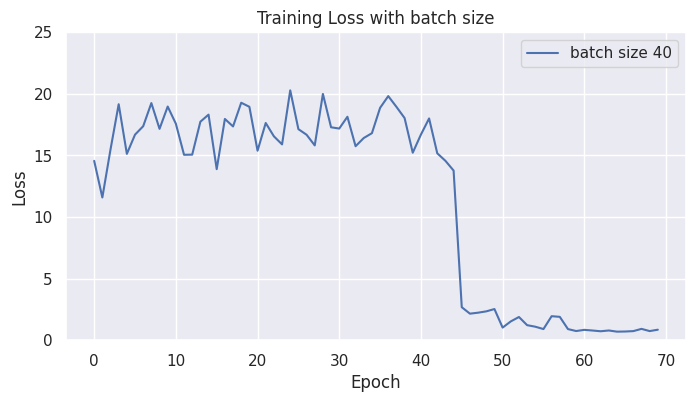

In [3]:
import seaborn as sns
sns.set_theme()
plt.rcParams["figure.figsize"] = (8,4)
x = range(70)
batch_10 = loadtxt('cartpole_loss_10.csv', delimiter=',')
batch_20 = loadtxt('cartpole_loss_20.csv', delimiter=',')
batch_40 = loadtxt('cartpole_loss_40.csv', delimiter=',')
# plt.plot(x,batch_10,label='batch size 10')
# plt.plot(x,batch_20,label='batch size 20')
plt.plot(x,batch_40,label='batch size 40')
plt.grid('on')
plt.ylabel('Loss')
plt.ylim(0,25)
plt.xlabel('Epoch')
plt.title('Training Loss with batch size')
plt.legend()

## Data Collection


In [15]:
Tini = 4
m = 1
p = 4
Tf = 25
T = (m+1)*(Tini + Tf + p) + 4
n_batch = 20
device = 'cuda' if torch.cuda.is_available() else 'mps'
# device = 'cpu'
print(device)
ud = loadtxt('../badcartpole_ud.csv', delimiter=',')
yd = loadtxt('../badcartpole_yd.csv', delimiter=',')
yd = yd.reshape(T*p,)
noise =  np.random.randn(*yd.shape)*0.001
noiseu =  np.random.randn(*ud.shape)*0.01
yd = yd + noise
ud = ud + noiseu
dx = CartpoleDx().to(device)
projection = Projection()
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

cuda


In [16]:
u_constraints = np.ones(Tf)*4
y_constraints = np.kron(np.ones(Tf), np.array([0.25, 0.2, 0.15, 0.2]))
r = torch.ones(m)*0.01
q = torch.ones(p)*100 
q = torch.Tensor([100,10,100,10])
lam_g1 = torch.Tensor([500.409]).to(device)
lam_g2 = torch.Tensor([0.01]).to(device)
lam_y = torch.Tensor([250.258]).to(device)
lam_u = torch.Tensor([250.258]).to(device)

controller = DDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, T=T, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic=True, q=q, r=r, lam_y=lam_y, lam_u=lam_u
).to(device)

In [17]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([199.9999], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([200.0008], device='cuda:0', requires_grad=True)


In [18]:
episodes = 20
ref = torch.zeros(size=(n_batch,p))
perfect = torch.kron(torch.ones(episodes+Tini), ref).to(device)
ref = torch.kron(torch.ones(Tf), ref).to(device)
n_row = np.sqrt(n_batch).astype(np.uint8)
n_col = n_row
opt = optim.Rprop(controller.parameters(), lr=0.01, step_sizes=(1e-4,50))
# opt = torch.optim.Adagrad(controller.parameters(), lr=100)

epochs = 60
pbar = tqdm(range(epochs))
cum_loss = []
done = False
I, PI = controller.get_PI()
PI = torch.Tensor(I-PI).to(device)

lam_g1, lam_g2 = np.zeros(epochs), np.zeros(epochs)

for j in pbar:
                                                                                                                                        
    uini = (torch.zeros(size=(n_batch, Tini*m)) + torch.randn(n_batch, Tini*m)*0.001).to(device)
    uini += torch.randn(uini.shape).to(device)*0.01
    zero = torch.zeros(n_batch)
    th = uniform((n_batch), -0.01, 0.01)
    yini = torch.stack((zero, zero, th, zero), dim=1).repeat(1,Tini)
    y = yini[:,-p:].to(device)
    yini += torch.randn(yini.shape)*0.001
    yini = yini.to(device)
    traj = yini
    G, Ey, Eu, Y, U = torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device)
    
    for i in range(episodes):
        
        g, u_pred, _, sig_y, sig_u = controller(ref=None, uref=None, y_ini=yini, u_ini=uini)
        
        G, Ey, Eu = torch.cat((G, g.unsqueeze(1)), axis=1), torch.cat((Ey, sig_y.unsqueeze(1)), axis=1), torch.cat((Eu, sig_u.unsqueeze(1)), axis=1)
        input = u_pred[:,:m] + torch.randn(u_pred[:,:m].shape).to(device)*0.01
        U = torch.cat((U, input.unsqueeze(1)), axis=1)
        y = dx(y, input)
        Y = torch.cat((Y, y.unsqueeze(1)), axis=1)
       
        noise = torch.randn(y.shape).to(device)*0.001
        y += noise
       
        yini = torch.cat((yini[:, p:], y), axis=1)
        uini = torch.cat((uini[:, m:], input), axis=1)
 
    loss = episode_loss(G=G, U=U, Y=Y, Ey=Ey, Eu=Eu, controller=controller, PI=PI)
    lam_g2[j] = controller.lam_g2.data.item()
    lam_g1[j] = controller.lam_g1.data.item()
    cum_loss.append(loss.item())
    opt.zero_grad()   
    loss.backward()
    opt.step()
    controller.apply(projection)

    pbar.set_description(f'l={loss.item():.3f}, ly={controller.lam_y.data.item():.3f},\
l1={controller.lam_g1.data.item():.3f}, l2={controller.lam_g2.data.item():.3f}, lu={controller.lam_u.data.item():.3f}')

l=0.410, ly=250.258,l1=200.018, l2=1.647, lu=250.258:  97%|█████████▋| 58/60 [26:59<01:41, 50.61s/it]   /opt/conda/envs/deepc/lib/python3.9/site-packages/diffcp/cone_program.py:295: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
l=0.880, ly=250.258,l1=199.996, l2=0.824, lu=250.258: 100%|██████████| 60/60 [29:14<00:00, 29.25s/it]


In [23]:
from numpy import savetxt
savetxt(f'lam_g1.csv', lam_g1, delimiter=',')
savetxt(f'lam_g2.csv', lam_g2, delimiter=',')

In [19]:
plt.rcParams["figure.figsize"] = (10,5)
# plt.rcParams['text.usetex'] = True

plt.plot(range(len(cum_loss)), cum_loss, 
         label=f'lambda_y : {controller.lam_y.data.item():.2f}\n\
        lambda_1 : {controller.lam_g1.data.item():.2f}\n\
        lambda_2 : {controller.lam_g2.data.item():.2f}, lambda_u = {controller.lam_u.data.item():.2f}')
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid('on')
plt.legend()
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x500 with 1 Axes>

In [ ]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([93.1931], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([263.3954], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0572], device='cuda:0', requires_grad=True)


In [ ]:
# vid_fname = 'cartpole.mp4'
# # if os.path.exists(vid_fname):
# #     os.remove(vid_fname)
# cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p {}'.format(
#     t_dir, vid_fname
# )
# os.system(cmd)
# # print('Saving video to: {}'.format(vid_fname))

# video = io.open(vid_fname, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))